# Week 1 Seminar

A/B experiment analysis

In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [2]:
experiment = "RECOMMENDERS"

In [3]:
data = pd.read_json("/Users/User/Desktop/data.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [4]:
# T1 - My method
# T2 - INDEXED
# T3 - STICKY_ARTIST
# C - RANDOM
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2022-03-27 21:25:30.531,3255,2659,1.00,1.600e-03,5856.0,"{'AA': 'C', 'RECOMMENDERS': 'T2'}",T2
1,next,2022-03-27 21:25:30.551,3255,5856,0.08,8.466e-04,1151.0,"{'AA': 'C', 'RECOMMENDERS': 'T2'}",T2
2,next,2022-03-27 21:25:30.566,3255,1151,0.01,6.874e-04,49737.0,"{'AA': 'C', 'RECOMMENDERS': 'T2'}",T2
3,next,2022-03-27 21:25:30.584,3255,49737,0.36,8.173e-04,7229.0,"{'AA': 'C', 'RECOMMENDERS': 'T2'}",T2
4,next,2022-03-27 21:25:30.600,3255,7229,0.80,7.982e-04,14701.0,"{'AA': 'C', 'RECOMMENDERS': 'T2'}",T2


## Visualize sessions

In [5]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [6]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

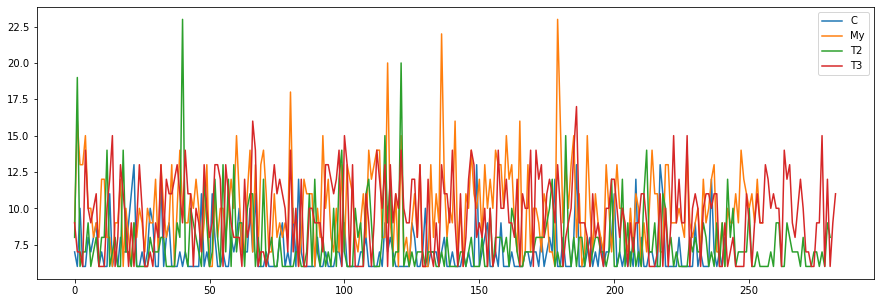

In [7]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

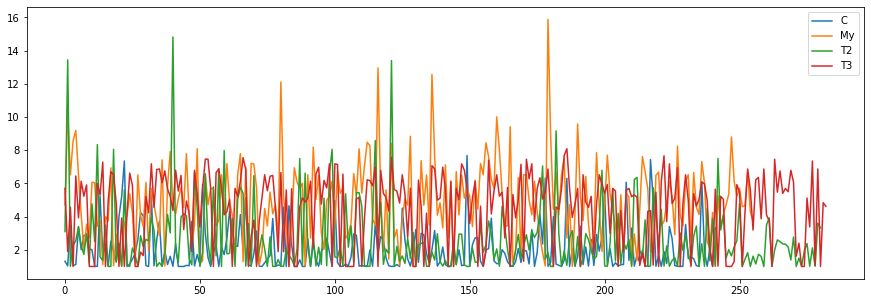

In [8]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [9]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [10]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [11]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [12]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values("treatment", ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
10,T3,time,120.176,140.384,99.969,2.372,5.223,True
11,T3,sessions,0.168,6.407,-6.072,1.158,1.160,False
12,T3,mean_request_latency,38.083,46.737,29.429,0.709,0.980,True
13,T3,mean_tracks_per_session,32.652,38.180,27.123,7.080,9.391,True
14,T3,mean_time_per_session,111.763,127.402,96.124,2.084,4.413,True
5,T2,time,28.175,46.535,9.815,2.372,3.041,True
6,T2,sessions,-0.540,5.952,-7.032,1.158,1.152,False
7,T2,mean_request_latency,9.083,11.033,7.134,0.709,0.774,True
8,T2,mean_tracks_per_session,7.046,11.986,2.105,7.080,7.579,True
9,T2,mean_time_per_session,22.365,37.056,7.673,2.084,2.550,True
